$\newcommand{\Sum}{\sum\limits}$
$\newcommand{\Prod}{\prod\limits}$
$\newcommand{\Max}{\max\limits}$
$\newcommand{\Min}{\min\limits}$
$\newcommand{\Int}{\int\limits}$
$\newcommand{\Exp}{\mathbb{E}}$
$\newcommand{\Var}{\mathbb{V}}$
$\newcommand{\Energy}{\mathcal{E}}$
$\newcommand{\Prob}{\mathcal{P}}$
$\newcommand{\N}{\mathcal{N}}$


$\newcommand{\LogLike}{\mathcal{L}}$
$\newcommand{\Like}{\ell}$

$\newcommand{\bolda}{\boldsymbol{a}}$
$\newcommand{\boldA}{\boldsymbol{A}}$
$\newcommand{\ba}{\bolda}$
$\newcommand{\bA}{\boldA}$

$\newcommand{\boldb}{\boldsymbol{b}}$
$\newcommand{\boldB}{\boldsymbol{B}}$
$\newcommand{\bb}{\boldb}$
$\newcommand{\bB}{\boldB}$

$\newcommand{\boldd}{\boldsymbol{d}}$
$\newcommand{\boldD}{\boldsymbol{D}}$
$\newcommand{\bd}{\boldd}$
$\newcommand{\bD}{\boldD}$

$\newcommand{\boldf}{\boldsymbol{f}}$
$\newcommand{\boldF}{\boldsymbol{F}}$
$\newcommand{\bf}{\boldf}$
$\newcommand{\bF}{\boldF}$

$\newcommand{\boldt}{\boldsymbol{t}}$
$\newcommand{\boldT}{\boldsymbol{T}}$
$\newcommand{\bt}{\boldsymbol{\boldt}}$
$\newcommand{\bT}{\boldsymbol{\boldT}}$

$\newcommand{\boldx}{\boldsymbol{x}}$
$\newcommand{\boldX}{\boldsymbol{X}}$
$\newcommand{\bx}{\boldx}$
$\newcommand{\bX}{\boldX}$

$\newcommand{\boldY}{\boldsymbol{Y}}$
$\newcommand{\boldy}{\boldsymbol{y}}$
$\newcommand{\bY}{\boldY}$
$\newcommand{\by}{\boldy}$

$\newcommand{\boldZ}{\boldsymbol{Z}}$
$\newcommand{\boldz}{\boldsymbol{z}}$
$\newcommand{\bZ}{\boldZ}$
$\newcommand{\bz}{\boldz}$

$\newcommand{\boldTheta}{\boldsymbol{\Theta}}$
$\newcommand{\boldtheta}{\boldsymbol{\theta}}$
$\newcommand{\bTheta}{\boldTheta}$
$\newcommand{\btheta}{\boldtheta}$

In [3]:
# Autosave each 30s
%autosave 30 

import numpy as np
import pandas as pd
import copy
import sys
sys.path.append('../library/')
import math
import scipy
import pickle as pkl

from scipy import stats
from scipy.special import erfc
from scipy.signal import fftconvolve
from itertools import product, chain
from collections import defaultdict, Counter
from tqdm import tqdm

#sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#skimage
import skimage
from skimage import io
from skimage.transform import resize

%load_ext autoreload
%autoreload 1
# Below comes the list of modules which is automatically reimported
%aimport helpers
%aimport gaussian_mixtures

from helpers import Checker, Printer
from gaussian_mixtures import *

#IPython imports
from IPython.display import display, clear_output

#matplotlib
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%matplotlib inline

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.01
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20
# Configuring latex fonts
matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', unicode=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}') 

Autosaving every 30 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='toc'></a>
# Содержание
* [Теория](#em_face_theory)
   * [E-шаг](#em_face_estep)
   * [M-шаг](#em_face_mstep)
       * [Максимизация по $\bA$](#em_face_mstepA)
       * [Максимизация по $\bF$](#em_face_mstepF)
       * [Максимизация по $\bB$](#em_face_mstepB)
       * [Максимизация по $\sigma$](#em_face_mstepS)
* [Реализация](#em_face_impl)
* [Применение](#em_face_appl)
    * [Тестирование на сгенерированных данных](#em_face_val)
    * [Распознавание лица на снимках](#em_face_test)
* [Интерфейсы](#interfaces)

<a id='em_face_theory'></a>
## Теория<sup>[toc](#toc)</sup>
* $I(\boldd)$ - множество координат точек лица на изображении
* $ $
* $M = E_{h \times w}$ - матрица из единиц размера $h\times w$
* $\mathcal{D} = [0, H - h] \times [0, W - w]$

\begin{gather}
\log p(\boldX|\boldd, \boldtheta) = \log \left(\Prod_{i,j\in I(\bd)} \N(\bX[i,j]|\bF[i-d^h,j-d^w], \sigma^2) \Prod_{i,j \notin I(\bd)} \N(\bX[i,j]|\bB[i,j], \sigma^2) \right) = \\ = \Sum_{(i,j)\in I(\boldd)} \left(-\frac{1}{2}\log(2\pi) - \log (\sigma) - \frac{(\bX[i,j] -\bF[i-d^h,j-d^w])^2}{2\sigma^2} \right)+ \Sum_{(i,j) \notin I(\bd)} \left(-\frac{1}{2}\log(2\pi) - \log (\sigma) - \frac{(\bX[i,j] -\bB[i,j])^2}{2\sigma^2} \right) = \\
= - \frac{HW}{2}\log(2\pi) - HW \log(\sigma) - \frac{1}{2\sigma^2}\Sum_{(i,j)\in I(\bd)} \left((\bX[i,j] - \bF[i-d^h,j-d^w])^2 - (\bX[i,j] - \bB[i,j])^2\right) - \frac{1}{2\sigma^2} \|\boldX - \boldB\|^2_2 = \\
= - \frac{HW}{2}\log(2\pi) - HW \log(\sigma) - \frac{1}{2\sigma^2} \|\bX - \bB\|^2_2 - \frac{1}{2\sigma^2}\Sum_{(i,j)\in I(\bd)} \left(\bF^2[i-d^h,j-d^w] - 2\bF[i-d^h,j-d^w]\bX[i,j] - \bB^2[i,j] + 2\bB[i,j]\bX[i,j]\right) = \\
= - HW\left(\frac{1}{2}\log(2\pi) + \log(\sigma)\right) - \frac{1}{2\sigma^2} \left(\|\boldX - \boldB\|^2_2 + \|\boldF\|_2^2\right) + \frac{1}{2\sigma^2} \Sum_{(i,j)\in I(\boldd)} \ \left(\bB^2[i,j] - 2\bB[i,j]\bX[i,j] + 2\bF[i-d^h,j-d^w]\bX[i,j]\right) = \\ 
= - HW\left(\frac{1}{2}\log(2\pi) + \log(\sigma)\right) - \frac{1}{2\sigma^2}\left(\|\bX - \bB\|^2_2 +  \|\bF\|_2^2\right) + \frac{1}{2\sigma^2}\left((\bB^2 - 2\bB \cdot \bX) \star M)[\bd] + 2(\boldX \star\boldF)[\bd] \right) = \\ = - HW\left(\frac{1}{2}\log(2\pi) + \log(\sigma)\right) - \frac{1}{2\sigma^2}\left(\|\boldX - \boldB\|^2_2 +  \|\boldF\|_2^2\right) + \frac{1}{2\sigma^2}\left((\bB^2 - 2\bB \bX) \star M + 2\boldX \star\boldF\right)[\boldd]. 
\end{gather}

\begin{gather}
\log p(\boldX, \boldd|\boldtheta, \boldA) = \log p(\boldd|\boldA) + \log p(\boldX|\boldd,\boldtheta) = \\= \log A(\boldd)- HW\left(\frac{1}{2}\log(2\pi) + \log(\sigma)\right) - \frac{1}{2\sigma^2}\left(\|\boldX - \boldB\|^2_2 +  \|\boldF\|_2^2\right) + \frac{1}{2\sigma^2}\left((\bB^2 - 2\bB \bX) \star M + 2\boldX \star\boldF\right)[\boldd].
\end{gather}

<a id='em_face_estep'></a>
### E-шаг<sup>[toc](#toc)</sup>
$$
p(\boldd|\boldX,\boldtheta, \boldA) = \frac{p(\boldX, \boldd|\boldtheta, \boldA)}{\Sum_{\boldd' \in \mathcal{D}} p(\boldX, \boldd'|\boldtheta, \boldA)} = \frac{p(\boldd|\boldA)p(\boldX|\boldd,\boldtheta)}{\Sum_{\boldd' \in \mathcal{D}} p(\boldd'|\boldA)p(\boldX|\boldd',\boldtheta)} = \frac{\exp\left(\log p(\boldd|\boldA) + \log p(\boldX|\boldd,\boldtheta) \right)}{\Sum_{\boldd' \in \mathcal{D}} \exp\left(\log p(\boldd'|\boldA) + \log p(\boldX|\boldd',\boldtheta)\right)}.
$$

$$
q(\boldd) = p(\boldd|\boldX,\boldtheta, \boldA) = \frac{\exp\left(\log \boldA(\boldd) + \frac{1}{2\sigma^2} \left((\boldB^2 - 2\boldB \cdot \boldX) \star M + 2 \boldX \star \boldF \right)[\boldd] \right)}{\Sum_{\boldd' \in \mathcal{D}}\exp\left(\log \boldA(\boldd') + \frac{1}{2\sigma^2} \left((\boldB^2 - 2\boldB \cdot \boldX) \star M +  2 \boldX \star \boldF \right)[\boldd']\right)}
$$

Будем хранить апостерирорные вероятности $p(\boldd|\boldX,\boldtheta, \boldA)$ в виде матрицы размера $(H - h + 1) \times (W - w + 1)$. Обозначим эту матрицу $\Gamma = \|p(\boldd|\boldX,\boldtheta, \boldA)\|_{\boldd} = \|\gamma_{\boldd}\|_{\boldd}$. На самом деле нам потребуются $K$ матриц апостериорных распределений $\{\Gamma_1, \dots, \Gamma_K\}$ по одной на каждое изображение.

В процессе вычислений оказывается, что для значительной части позиций $\boldd \in \mathcal{D}$ априорная вероятность попасть в них стремится к нулю: $\bA(\bd) \rightarrow 0$. 

Рассмотрим ситуацию, когда $s \rightarrow 0$, и при этом фон полностью одноцветный, т.е. $\bB^*[i, j] = b \in [0, 1]$. Будем считать, что перед первой итерацией инициализация $\bA$ равномерная $\bd(A) = 1 / |\mathcal{D}|$.

<a id='em_face_mstep'></a>
### M-шаг<sup>[toc](#toc)</sup>
$$
\mathcal{L}(X|\boldtheta,\boldA) = \Exp_{\boldd_k \backsim q_k(\boldd)} \log \left(\prod_{k=1}^K p(\boldX_k,\boldd_k|\boldtheta,\boldA)\right) = \Sum_{k=1}^K \Sum_{\boldd \in \mathcal{D}} p(\boldd|\boldX_k,\boldtheta,\boldA)\log p(\boldX_k,\boldd|\boldtheta,\boldA) = \Sum_{k=1}^K \Sum_{\boldd \in \mathcal{D}} \gamma_{k\boldd} \log p(\boldX_k,\boldd|\boldtheta,\boldA) \rightarrow \max_{\boldtheta, \boldA}\\
\mathcal{L}(X|\boldtheta,\boldA) = \Sum_{k=1}^K \Sum_{\boldd \in \mathcal{D}} \gamma_{k\boldd}\left(\log A(\boldd) - HW\left(\frac{1}{2}\log(2\pi) + \log(\sigma)\right) - \frac{1}{2\sigma^2}\left(\|\boldX_k - \boldB\|^2_2 +  \|\boldF\|_2^2\right) + \frac{1}{2\sigma^2}\left((\boldB^2 - 2\boldB \cdot \boldX_k) \star M + 2 \boldX \star\boldF\right)[\boldd]\right).
$$

<a id='em_face_mstepA'></a>
#### Максимизация по $\boldA$<sup>[toc](#toc)</sup>
$$
\frac{\partial \mathcal{L}}{\partial \boldA[i,j]} = \frac{\Sum_{k=1}^K\gamma_{k\boldd}}{\boldA[i,j]} - \lambda  = 0 \Rightarrow \lambda = K.
$$
В покомпонентном виде:
$$
\boldA^{(new)}[i, j] = \frac{1}{K}\Sum_{k=1}^K \gamma_{k\boldd}.
$$
В матричном виде:
$$
\boldA^{(new)} = \frac{1}{K} \Sum_{k=1}^K \Gamma_k.
$$
По окончании M шага значение $\bA$ оказывается равно среднему от значений $\Gamma_k$ после $E$-шага.

В процессе вычисления возникает ситуация, когда некоторая позиция $\boldd \in \mathcal{D}$ искомого изоражения не представлена ни на одном из снимков. В таком случае $\gamma_{k\boldd} \rightarrow 0$ для всех $k \in \{1, \dots, K\}$. Из формул выше следует, что при этом $\bA(\boldd) \rightarrow 0$. 

<a id='em_face_mstepF'></a>
#### Максимизация по $\boldF$<sup>[toc](#toc)</sup>
$$
\frac{\partial \mathcal{L}}{\partial \boldF[i,j]} = \Sum_{k=1}^K \Sum_{\boldd \in \mathcal{D}} \gamma_{k\boldd}
\left(-\frac{\boldF[i,j]}{\sigma^2} + \frac{\bX_k[d^h+i, d^w + j]}{\sigma^2} \right) = \Sum_{k=1}^K\left(-\frac{\boldF[i, j]}{\sigma^2} + \Sum_{\boldd \in \mathcal{D}} \frac{\gamma_{k\boldd}\bX_k[d^h+i, d^w+j]}{\sigma^2}\right) = \frac{1}{\sigma^2}\left(-K\boldF[i,j] + \Sum_{k=1}^K\Sum_{\boldd \in \mathcal{D}} \gamma_{k\boldd}\bX_k[d^h + i, d^w + j]\right), \quad i, j \in [0, h - 1] \times [0, w - 1].
$$
Изучим вторую сумму. Хотелось бы найти быстрый способ ее матричного вычисления. Рассмотрим вычисления для одного изображения $k \in \{1, \dots, K\}$.
Будем смотреть на сумму
$$
\Sum_{\boldd \in \mathcal{D}} \gamma_{\boldd}\boldX[d^h + i, d^w + j]
$$
как на элемент некоторой матрицы $\boldT$ размера $h\times w$:
$$
\boldT[i,j] = \Sum_{\boldd \in \mathcal{D}} \gamma_{\boldd}\boldX[d^h + i, d^w + j] 
$$
Тогда сама матрица $\bT$ имеет вид:
$$
\bT = \Sum_{\boldd \in \mathcal{D}} \gamma_{\boldd}\boldX[d^h\colon d^h + h, d^w\colon d^w + w],
$$
где 
$\boldX[d^h\colon d^h + h, d^w\colon d^w + w] \triangleq \boldX(\boldd) - $
это подматрица матрицы $\boldX$ размера $h \times w$ и левым верхним углом в координате $\boldd$.

Рассмотрим свертку $\bX\star\Gamma$. Она имеет размер $h \times w$. 
$$
(\bX \star \Gamma)[i, j] = \Sum_{(u,v) \in [0, H-h]\times [0, W - w]} \Gamma[u, v] \bX[i + u, j + v], \quad i, j \in [0, h-1] \times [0, w-1].
$$
В иных обозначениях получаем
$$
(\bX \star  \Gamma )[i, j] = \Sum_{\bd \in \mathcal{D}} \gamma_\bd \bX[d^h + i, d^w + j] = \bT[i, j].
$$
Поэтому 
$$
\bT = \bX \star \Gamma.
$$
Наконец,
$$
\frac{\partial \mathcal{L}}{\partial \bF} = \frac{1}{\sigma^2}\left(-K\bF  + \Sum_{k=1}^K \Gamma_k \star \bX_k\right) \Rightarrow \bF^{(new)} = \frac{1}{K} \Sum_{k=1}^K \Gamma_k \star \bX_k.
$$

<a id='em_face_mstepB'></a>
#### $\boldB$<sup>[toc](#toc)</sup>
В покомпонентном виде:
$$
\frac{\partial \mathcal{L}}{\partial \bB[i,j]} = \frac{1}{\sigma^2} \Sum_{k=1}^K\Sum_{\bd \in \mathcal{D}}  \gamma_{k\bd}  \left((\bX_k[i, j] - \bB[i, j]) - (\bX_k[i,j] - \bB[i,j])[(i,j) \in I(\bd)]\right) = \frac{1}{\sigma^2} \Sum_{k=1}^K \Sum_{\bd \in \mathcal{D}} \gamma_{k\bd}\left(\bX_k[i,j] - \bB[i,j] \right) (1 - [(i, j) \in I(\bd)]) = \\
\frac{1}{\sigma^2} \Sum_{k=1}^K (\bX_k[i, j] - \bB[i,j])\Sum_{\bd \in \mathcal{D}}\left(\gamma_{k\bd} - \gamma_{k\bd}[(i, j) \in I(\bd)]\right) = \frac{1}{\sigma^2} \Sum_{k=1}^K (\bX_k[i, j] - \bB[i,j]) \left(1 - \Sum_{\bd \in \mathcal{D}} \gamma_{k\bd}[(i, j) \in I(\bd)]\right) 
$$
В матричном виде:
$$
\frac{\partial \mathcal{L}}{\partial \bB} = \frac{1}{\sigma^2} \Sum_{k=1}^K (\bX_k - \bB) \left(E_{H\times W} - \Sum_{\bd \in \mathcal{D}} \gamma_{k\bd} E_{H\times W}(\bd)\right)
$$
$$
\left(\Sum_{\bd \in \mathcal{D}} \gamma_{\bd} E_{H\times W}(\bd)\right)[i, j] =  \Sum_{(u,v) \in [0, h-1]\times[0,w-1]} \Gamma[i - u, j - v] = \\ = \Sum_{(u,v) \in [0, h-1]\times[0,w-1]} \Gamma[i - (h - 1) + u, j - (w - 1) + v] =  (M \star \Gamma)[i - h + 1, j - w + 1],\quad (i,j) \in [0, H-1]\times [0, W - 1]
$$

Рассмотрим свертку матрицы $M$ с расширенной матрицей $\tilde{\Gamma}$ размера $(H + h - 1) \times (W + w - 1)$:
$$
\tilde{\Gamma}[i,j] = 
\begin{cases}
\Gamma[i - h + 1, j - w + 1], &\text{ если } (i, j) \in [h - 1, H - 1] \times [w - 1, W - 1];\\
0, &\text{ иначе }.
\end{cases}
$$
Свертка $M \star \tilde{\Gamma}$ $-$ это матрица размера $H \times W$. В таком случае:
$$
\frac{\partial \mathcal{L}}{\partial \bB} = \frac{1}{\sigma^2} \Sum_{k=1}^K (\bX_k - \bB) \left(E_{H\times W} - M \star \tilde{\Gamma}_k\right) \Rightarrow \bB^{(new)} = \frac{\Sum_{k=1}^K \bX_k \cdot (E_{H\times W} - M \star \tilde{\Gamma}_k)}{\Sum_{k=1}^K(E_{H\times W} - M \star \tilde{\Gamma}_k)}
$$

Выясним, может ли знаменатель обращаться в нуль в некоторых своих компонентах.
$$
\Sum_{k=1}^K (E_{H\times W} - M \star \tilde{\Gamma}_k)[i,j] = 0 \Rightarrow (M \star \tilde{\Gamma}_k)[i, j] = 1, \quad k \in \{1, \dots, K\}.
$$
$$
(M \star \tilde{\Gamma}_k)[i, j] = \Sum_{(u, v) \in [0, h - 1]\times [0, w - 1]} \tilde{\Gamma}_k[i + u, j + v] =  \Sum_{\substack{(u, v) \in [0, h - 1]\times [0, w - 1] \\ u \in [h - 1 - i, H - i] \\ v \in [w - 1 - j, H - j]}}\Gamma_k[i + u - h + 1, j + v - w + 1]
$$
* В $\tilde{\Gamma}$ суммирование по прямоугольнику $[\max(i, h - 1), \min(i + h - 1, H - 1)] \times [\max(j, w - 1), \min(i + w - 1, W - 1)]$, при $i \in [0, H - 1]$, $j \in [0, W - 1]$.
* В $\Gamma$ суммирование по прямоугольнику $[\max(i - h + 1, 0), \min(i, H - h)] \times [\max(j - w + 1, 0), \min(i, W - w)]$, при $i \in [0, H - 1]$, $j \in [0, W - 1]$.

Равенство единице элемента $(M \star \tilde{\Gamma}_k)[i, j]$ означает, что в данном прямоугольнике суммирования сосредоточены вероятности абсолютно всех $\bd_k$. Такая ситуация гарантированно возникает, если искомое изображение настолько велико, что при любом его расположении часть пикселей основного изображения всегда затирается. Это происходит при выполнении услвоий $h > H / 2$, $w > W / 2$. Заметим. что в таком случае затираемый пиксель $\bB[i,j]$ вообще не появляется в логарифме правдободобия, поэтому его можем положить равным нулю.

<a id='em_face_mstepS'></a>
#### Максимизация по $\sigma$<sup>[toc](#toc)</sup>
$$
\frac{\partial \mathcal{L}}{\partial \sigma} = \Sum_{k=1}^K\Sum_{\bd \in \mathcal{D}} \gamma_{k\bd}\left(-\frac{HW}{\sigma} + \frac{1}{\sigma^3}\left(\|\bX_k - \bB\|^2_2 + \|\bF\|^2_2 \right) - \frac{1}{\sigma^3} \left((\bB^2 - 2\bB\cdot \bX_k) \star M + 2 \bX_k \star \bF \right)[\bd] \right) = \\
= -\frac{KHW}{\sigma} + \frac{1}{\sigma^3}\Sum_{k=1}^K\Sum_{\bd \in \mathcal{D}} \gamma_{k\bd}\left(\|\bX_k - \bB\|^2_2 + \|\bF\|^2_2 - \left((\bB^2 - 2\bB\cdot \bX_k) \star M + 2 \bX_k \star \bF \right)[\bd] \right) = \\
= -\frac{KHW}{\sigma} + \frac{1}{\sigma^3}\Sum_{k=1}^K\left(\|\bX_k - \bB\|^2_2 + \|\bF\|^2_2 - \Sum_{\bd \in \mathcal{D}} \gamma_{k\bd}\left((\bB^2 - 2\bB\cdot \bX_k) \star M + 2 \bX_k \star \bF \right)[\bd] \right).
$$
Обозначим 
$$
S_k = \Sum_{\bd \in \mathcal{D}} \gamma_{k\bd}\left((\bB^2 - 2\bB\cdot \bX_k) \star M + 2 \bX_k \star \bF\right)[\bd] = \text{sum}(\Gamma_k \cdot \left((\bB^2 - 2\bB\cdot \bX_k) \star M +2 \bX_k \star \bF  \right)).
$$
Тогда 
$$
\frac{\partial \mathcal{L}}{\partial \sigma} =  -\frac{KHW}{\sigma} + \frac{1}{\sigma^3}\Sum_{k=1}^K\left(\|\bX_k - \bB\|^2_2 + \|\bF\|^2_2 - S_k \right) \Rightarrow (\sigma^2)^{(new)} = \frac{\Sum_{k=1}^K\left(\|\bX_k - \bB\|_2^2 + \|\bF\|^2_2 - S_k \right)}{KHW}
$$

<a id='em_face_impl'></a>
# Реализация<sup>[toc](#toc)</sup>

In [4]:
from scipy.signal import convolve
from scipy.signal import fftconvolve

class DetectionAlgorithm(Checker):
    INIT    = 3
    STEPS   = 3
    INIT_EM = 2
    WARNING = 1
    PRINT_L = 1    
    
    def __init__(self, images, h, w, copy=False, use_map=False, 
                 init='random', seed=1, max_iters=100, rel_stop_diff=1e-6,
                 eps=1e-10, use_asserts=False, verbose=0):
        self._verbose = verbose
        super().__init__()
        self._set_images(images, copy)
        self._set_init(init)
        
        self._setters = {'h': self.__set_positive_int,
                         'w': self.__set_positive_int,
                         'seed': self.__set_positive_int,
                         'max_iters': self.__set_positive_int,
                         'rel_stop_diff': self.__set_positive_number,
                         'eps': self.__set_positive_number,
                         'use_asserts': self.__set_boolean,
                         'use_map': self.__set_boolean}
        self._setters['h'](h, 'h')
        self._setters['w'](w, 'w')
        self._setters['seed'](seed, 'seed')
        self._setters['max_iters'](max_iters, 'max_iters')
        self._setters['rel_stop_diff'](rel_stop_diff, 'rel_stop_diff')
        self._setters['eps'](eps, 'eps')
        self._setters['use_asserts'](use_asserts, 'use_asserts')
        self._setters['use_map'](use_map, 'use_map')
        self._A_locked = False
        self._B_locked = False
        self._F_locked = False
        self._G_locked = False
        self._s_locked = False
        
    def _set_init(self, init):
        if init in ['random', 'uniform']:
            self._init = init
            self._printers[self.INIT](self._method_msg('_set_init({})'.format(init)))
        else:
            raise ValueError(self._method_msg('_set_init({})'.format(init)) + 
                             ': init must be either "random" or "uniform".')
    def _set_images(self, images, copy):
        self._check_type(images, 'images', np.ndarray)
        if not (len(images.shape) == 3):
            raise ValueError('Provided "images" array must have shape (K, H, W)')
        self._check_array_range(images, (0, 1.), 'images')

        self._K, self._H, self._W = images.shape
        if copy:
            self.X = np.array(images)
        else:
            self.X = images
        self._printers[self.INIT](self._method_msg('_set_images') +
                                  ': {} images of shape {} are set'.format(self._K, (self._H, self._W))) 
    
    def __set_positive_int(self, value, name):
        self._set_positive_int(value, '_' + name)
        self._printers[self.INIT](self._method_msg('_set_{}({})'.format(name, value)))
    def __set_positive_number(self, value, name):
        self._set_positive_number(value, '_' + name)
        self._printers[self.INIT](self._method_msg('_set_{}({})'.format(name, value)))
    def __set_boolean(self, value, name):
        self._set_boolean(value, '_' + name)
        self._printers[self.INIT](self._method_msg('_set_{}({})'.format(name, value)))
        
    def get_F(self, copy=True):
        if copy: return np.array(self.F)
        return self.F
    def get_B(self, copy=True):
        if copy: return np.array(self.B)
        return self.B
    def get_A(self, copy=True):
        if copy: return np.array(self.A)
        return self.A
    def get_G(self, copy=True):
        if copy: return np.array(self.G)
        return self.G
    def get_s(self):
        return self.s
    
    # Интерфейс для пользователей класса. В любом случае переписывает значения текущих массивов, если они 
    # уже созданы
    def set_A(self, init='random', copy=True):
        self._initialize_array('A', init, copy, rewrite=True)
    def set_B(self, init='random', copy=True):
        self._initialize_array('B', init, copy, rewrite=True)
    def set_F(self, init='random', copy=True):
        self._initialize_array('F', init, copy, rewrite=True)
    def set_G(self, init='random', copy=True):
        self._initialize_array('G', init, copy, rewrite=True)
    def set_s(self, s):
        assert s > 0
        self.s = s
    
    # Интерфейс для блокирования изменений определенных параметров
    def lock_A(self):
        self._A_locked = True
    def unlock_A(self):
        self._A_locked = False
    def lock_B(self):
        self._B_locked = True
    def unlock_B(self):
        self._B_locked = False
    def lock_G(self):
        self._G_locked = True
    def unlock_G(self):
        self._G_locked = False
    def lock_F(self):
        self._F_locked = True
    def unlock_F(self):
        self._F_locked = False
    def lock_s(self):
        self._s_locked = True
    def unlock_s(self):
        self._s_locked = False
        
    def __call__(self):
        self._initialize(self._seed)
        lower_bound = self._calculate_lower_bound()
        self._lower_bounds.append(lower_bound)
        self._printers[self.PRINT_L]('\tn_iter = {}: lower_bound = {}'.format(self._n_iter_init - 1, lower_bound))
        while True:
            self._run_e_step()
            self._run_m_step()
            lower_bound = self._calculate_lower_bound()
            self._lower_bounds.append(lower_bound)
            self._printers[self.PRINT_L]('\tn_iter = {}: lower_bound = {}'.format(self._n_iter, lower_bound))
            self._n_iter += 1
            if self._stop():
                break
        self._n_iter_init = self._n_iter
        return self.get_F()
    
    def _stop(self):
        if self._n_iter >= self._n_iter_init + self._max_iters:
            return True
        new_L  = self._lower_bounds[-1]
        prev_L = self._lower_bounds[-2]
        rel_diff = (prev_L - new_L) / prev_L
        if new_L < prev_L:
            warning_msg = self._warning_msg('Lower bound decreased from {:.4f} to {:.4f} at iter {}.'.format(
                prev_L, new_L, self._n_iter - 1))
            self._printers[self.WARNING](warning_msg)
        if abs(rel_diff) < self._rel_stop_diff:
            return True
        return False
    
    ############################
    ####   INITIALIZATION  #####
    ############################
    def _initialize(self, seed):
        if hasattr(self, '_n_iter'):
            self._printers[self.INIT](self._method_msg('_initialize') + 
                ': continuing calculations starting from n_iter = {}'.format(self._n_iter_init))
            return
        np.random.seed(seed)
        self._printers[self.INIT](self._method_msg('_initialize') + 
                                  ': performing {} initialization'.format(self._init))
        self._initialize_array('A', self._init, rewrite=False)
        self._initialize_array('B', self._init, rewrite=False)
        self._initialize_array('F', self._init, rewrite=False)
        self._initialize_array('G', self._init, rewrite=False)
        self.s = 1.0 + 10 * np.random.random()

        self.M = np.ones((self._h, self._w))
        self._n_iter = 0
        self._n_iter_init = 0
        self._lower_bounds = []
        self._printers[self.INIT_EM](self._method_msg('_initialize') + 
                                     ': parameters A({}), B({}), F({}) and s({}) are initialized.'.format(
                                     self.A.shape, self.B.shape, self.F.shape, self.s))
   
    def _initialize_array(self, arr_name, init, copy=True, rewrite=False):
        assert arr_name in ['A', 'B', 'F', 'G']
        if (not rewrite) & (hasattr(self, arr_name)): # Массив уже есть и его нельзя переписывать
            return
        if isinstance(init, np.ndarray):
            if copy: arr_value = np.array(init)
            else: arr_value = init
        elif isinstance(init, str):
            assert init == 'random'
            arr_value = self._get_random_array(arr_name)
        else:
            assert False
        self._set_array(arr_name, arr_value)
        
    def _get_random_array(self, arr_name):
        assert arr_name in ['A', 'B', 'F', 'G']
        getter = self.__getattribute__('_get_random_' + arr_name)
        return getter()
    def _get_random_A(self):
        A = np.random.random((self._H - self._h + 1, self._W - self._w + 1))
        A = np.maximum(A, self._eps)
        A /= np.sum(A)
        #A = np.ones((self._H - self._h + 1, self._W - self._w + 1))
        #A /= (self._H - self._h + 1) * (self._W - self._w + 1)
        return A
    def _get_random_B(self):
        B = np.random.random((self._H, self._W))
        #B = np.full((self._H, self._W), 0.5)
        return B
    def _get_random_F(self):
        F = np.random.random((self._h, self._w))
        return F
    def _get_random_G(self):
        G = np.random.random((self._K, self._H  - self._h + 1, self._W - self._w + 1))
        G = np.maximum(G, self._eps)
        G /= np.sum(np.sum(G, axis=2), axis=1)[:, None, None]
        #G = np.ones((self._K, self._H  - self._h + 1, self._W - self._w + 1)) / ((self._H - self._h + 1) * (self._W - self._w + 1))
        return G
    
    def _set_array(self, arr_name, arr_value):
        assert arr_name in ['A', 'B', 'F', 'G']
        assert isinstance(arr_value, np.ndarray)
        setter = self.__getattribute__('_set_array_' + arr_name)
        return setter(arr_value)
    def _set_array_A(self, A):
        assert A.shape == (self._H - self._h + 1, self._W - self._w + 1)
        assert np.allclose(np.sum(A), 1.0)
        self.A = A
    def _set_array_B(self, B):
        self.B = B
        self.temp_B2 = self.B**2
        self.temp_sum_BX = ((self.X - self.B[None, :, :])**2).sum(2).sum(1)
    def _set_array_F(self, F):
        self.F = F
        self.temp_sum_F2 = np.sum(self.F**2)
    def _set_array_G(self, G):
        self.G = G
            
    def _assert(self, condition, msg=''):
        assert condition, msg
    def _assert_nans(self, arr, arr_name=''):
        self._assert(not np.any(np.isnan(arr)), 'Array {} contains nans'.format(arr_name))
    def _assert_shape(self, arr, shape, arr_name=''):
        self._assert(arr.shape == shape, 'Expected {}.shape = {}, but got {}.shape = {}'.format(
            arr_name, shape, arr_name, arr.shape))
            
    ######################
    ##   E,M-steps      ##
    ######################     
    def _run_e_step(self):
        self._printers[self.STEPS](self._method_msg('_run_e_step'))
        if self._G_locked:
            return self.G
        
        H = self._H; W = self._W; K = self._K; h = self._h; w = self._w
        logA = np.log(self.A)
        self.G = []
        
        logP = self._calculate_log_probability()
        self.G = logP + logA[None, :, :]
        self._softmax(self.G, [1, 2])

        """for k in range(K):
            M_BX = fftconvolve(self.B ** 2 - 2 * np.multiply(self.B, self.X[k]), self.M, mode='valid') # (H - h + 1, W - w + 1)
            F_X  = fftconvolve(2 * self.X[k], self.F[::-1, ::-1], mode='valid')                        # (H - h + 1, W - w + 1)
            G = logA + 0.5 * (M_BX + F_X) / (self.s**2)
            G = G - np.max(G);
            G = np.exp(G)
            G /= np.sum(G)
            self.G.append(G[None, :, :])
        self.G = np.concatenate(self.G, axis=0)"""
        
        if self._use_asserts:
            self._assert_nans(logA, 'log(A)')
            self._assert_shape(self.G, (K, H - h + 1, W - w + 1), 'G')
            self._assert_nans(self.G, 'G')
            self._assert(np.allclose(self.G.sum(axis=2).sum(axis=1), 1))

    def _softmax(self, X, axes):
        axes = sorted(axes)
        X_max = np.apply_over_axes(np.max, X, axes)
        X -= X_max
        np.exp(X, X)
        X_sum = np.apply_over_axes(np.sum, X, axes)
        X /= X_sum

    def _run_m_step(self):
        self._printers[self.STEPS](self._method_msg('_run_m_step'))
        H = self._H; W = self._W; K = self._K; h = self._h; w = self._w

        # Estimating A
        if not self._A_locked:
            self.A = np.mean(self.G, axis=0)
            
        # Estimating F
        if not self._F_locked:
            F = np.zeros((h, w))
            for k in range(K):
                G_X = fftconvolve(self.X[k], self.G[k][::-1, ::-1], mode='valid')
                F += G_X
            self.F = F / K
            self.temp_sum_F2 = np.sum(self.F**2)

        # Estimating B
        if not self._B_locked:
            numerator   = np.zeros((H, W))
            denominator = np.zeros((H, W))
            for k in range(K):
                M_G = fftconvolve(self.G[k], self.M, mode='full')
                temp = np.ones((H, W)) - M_G
                temp = np.minimum(temp, 1.0)
                temp = np.maximum(temp, 0.0)
                numerator += np.multiply(self.X[k], temp)
                denominator += temp
            denominator[denominator == 0] = self._eps
            self.B = np.divide(numerator, denominator)
            self.temp_B2 = self.B ** 2
            self.temp_sum_BX = ((self.X - self.B[None, :, :])**2).sum(2).sum(1)
            
        # Estimating s
        if not self._s_locked:
            S = self.temp_sum_F2 / (H * W)
            for k in range(K):
                M_BX = fftconvolve(self.temp_B2 - 2 * np.multiply(self.B, self.X[k]), self.M, mode='valid')
                F_X = fftconvolve(2 * self.X[k], self.F[::-1,::-1], mode='valid')
                S += (self.temp_sum_BX[k] - np.sum(np.multiply(self.G[k], M_BX + F_X))) / (K * H * W)
            self.s = np.sqrt(S)
            
        if self._use_asserts:
            #TODO Реализовать проверки всех значений
            pass

    
    def _calculate_log_probability(self):
        """
        Calculates log p(X_k|d_k,F,B,s) for all images X_k in X and
        all possible displacements d_k. shape(K, H-h+1, W-w+1)
        """
        H = self._H; W = self._W; K = self._K; h = self._h; w = self._w
        C = - H * W * (0.5 * np.log(2 * np.pi) + np.log(self.s)) - 0.5 * np.sum(self.temp_sum_F2) / (self.s**2)
        LL = np.full((K, H - h + 1, W - w + 1), C, dtype=np.float64)
        for k in range(K):
            LL[k] -= 0.5 * np.sum((self.X[k] - self.B)**2) / (self.s**2)
            M_BX = fftconvolve(self.B**2 - 2 * np.multiply(self.B, self.X[k]), self.M, mode='valid')
            F_X  = fftconvolve(2 * self.X[k], self.F[::-1,::-1], mode='valid')
            LL[k] += 0.5 * (M_BX + F_X) / (self.s**2)
        return LL
    
    def _calculate_lower_bound(self):
        """
        Calculates the lower bound L(q,A,F,B,s) for the marginal log likelihood.
        """
        H = self._H; W = self._W; K = self._K; h = self._h; w = self._w
        L = - 0.5 * H * W * K * (np.log(2 * np.pi) + 2 * np.log(self.s)) -\
            0.5 * K * np.sum(self.F**2) / (self.s ** 2)
        
        logA = np.log(self.A)
        logA[logA == -np.inf] = self._eps
        
        for k in range(K):
            L += np.sum(np.multiply(logA, self.G[k]))
            M_BX = fftconvolve(self.B ** 2 - 2 * np.multiply(self.B, self.X[k]), self.M, mode='valid') #  (H - h + 1, W - w + 1)
            F_X  = fftconvolve(2 * self.X[k], self.F[::-1, ::-1], mode='valid') # (H - h + 1, W - w + 1)
            L -= 0.5 * (np.sum((self.X[k] - self.B)**2) - np.sum(np.multiply(self.G[k], M_BX + F_X))) / (self.s**2)

        if self._use_asserts:
            self._assert_nans(logA, 'log(A)')
            self._assert_nans(L, 'L')
        return L

<a id='em_face_appl'></a>
# Применение<sup>[toc](#toc)</sup>

<a id='em_face_val'></a>
## Тестирование на синтетических данных<sup>[toc](#toc)</sup>

H = 25, W = 30


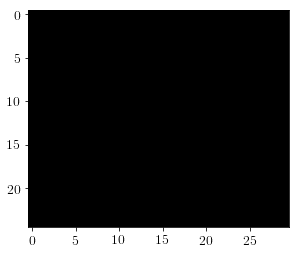

In [5]:
B_img = io.imread('parket.jpg', as_grey=True)
B_img = resize(B_img, output_shape=(30, 40))
B_img = np.full((25, 30), 0.5)
H, W = B_img.shape
print('H = {}, W = {}'.format(H, W))
plt.imshow(B_img, cmap='gray', interpolation='none')

h = 20, w = 20


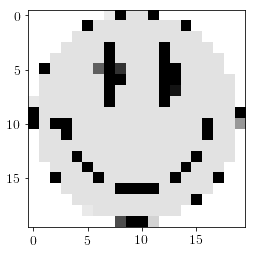

In [6]:
F_img = io.imread('smile.png', as_grey=True)
F_img = resize(F_img, output_shape=(20, 20))
h, w = F_img.shape
print('h = {}, w = {}'.format(h, w))
plt.imshow(F_img, cmap='gray', interpolation='none')

(1000, 25, 30) (1000, 6, 11)
LL = -548474.9621260854


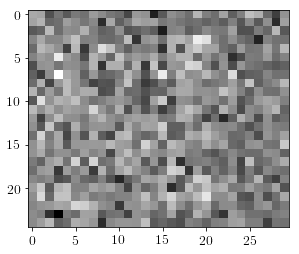

In [7]:
A_true = np.ones((H - h + 1, W - w + 1))
A_true /= (H - h + 1) * (W - w + 1)
F_true = F_img
F_mask = F_img > -1
B_true = B_img
s_true = 0.5

K = 1000
X = []; D = []; G = []; S = []
log_likelihood = 0

for k in range(K):
    dh = np.random.choice(H - h + 1)
    dw = np.random.choice(W - w + 1)
    D.append((dh, dw))
    Gk = np.zeros((H - h + 1, W - w + 1))
    Gk[dh, dw] = 1.0
    G.append(Gk[None, :, :])
    log_likelihood += np.log(A_true[dh, dw])
    
    B_mask = np.zeros((H, W))
    h_indices = list(range(dh, dh + h))
    w_indices = list(range(dw, dw + w))
    B_mask[np.ix_(h_indices, w_indices)] = F_mask
    B_mask = B_mask.astype(bool)
    
    new_img = np.array(B_img)
    new_img[B_mask] = F_img[F_mask]
    noise = np.random.normal(loc=0, scale=s_true, size=(H, W))
    log_likelihood += -np.sum(0.5 * np.log(2 * np.pi * s_true**2) + 0.5 * noise**2 / (s_true**2))
    new_img += noise
    S.append(np.max(new_img) - np.min(new_img))
    new_img -= np.min(new_img)
    new_img /= np.max(new_img)
    X.append(new_img[None, :, :])
X = np.concatenate(X, axis=0)
G_true = np.concatenate(G, axis=0)
print(X.shape, G_true.shape)
plt.imshow(X[-1], cmap='gray', interpolation='none')
print('LL = {}'.format(log_likelihood))

20 20
	n_iter = -1: lower_bound = -1709056.3339211764
	n_iter = 0: lower_bound = 291439.34951392416
	n_iter = 1: lower_bound = 303725.66606443375
	n_iter = 2: lower_bound = 366238.40561774373
	n_iter = 3: lower_bound = 371445.8392386669
	n_iter = 4: lower_bound = 371445.8392386677


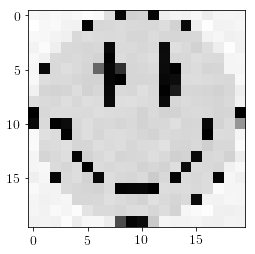

In [8]:
#h = 100; w = 75
h, w = F_img.shape
print(h, w)
algorithm = DetectionAlgorithm(X, h, w, verbose=1, eps=1e-20, max_iters=20, seed=5)
#algorithm.set_A(A_true); algorithm.lock_A()
#algorithm.set_G(G_true); algorithm.lock_G()

F = algorithm()
for n_reinit in range(0):
    print('reinit {}'.format(n_reinit))
    algorithm.reinit_G()
    F = algorithm()
plt.imshow(F, cmap='gray', interpolation='none')

<a id='em_face_test'></a>
## Распознавание лица на снимках<sup>[toc](#toc)</sup>

In [4]:
X = np.load('dataShad1000_2017.npy')
print(X.shape)
X = X.transpose([2, 0, 1])
print(X.shape)
K, H, W = X.shape
print('K = {}, H = {}, W = {}'.format(K, H, W))
X /= 255
print(np.min(X), np.max(X))

(104, 210, 1000)
(1000, 104, 210)
K = 1000, H = 104, W = 210
0.0 1.0


In [7]:
from IPython import display
h = 100; w = 75
algorithm = DetectionAlgorithm(X, h, w, eps=1e-20, max_iters=1, verbose=0, seed=1, rel_stop_diff=1e-7)

L = -13647470.095801977


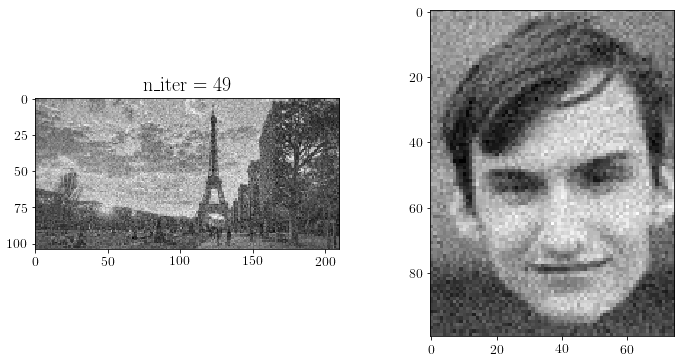

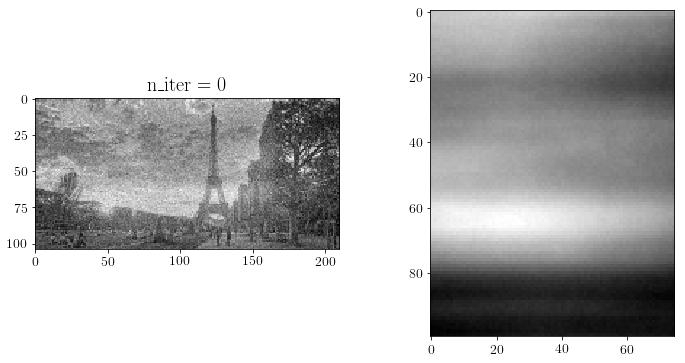

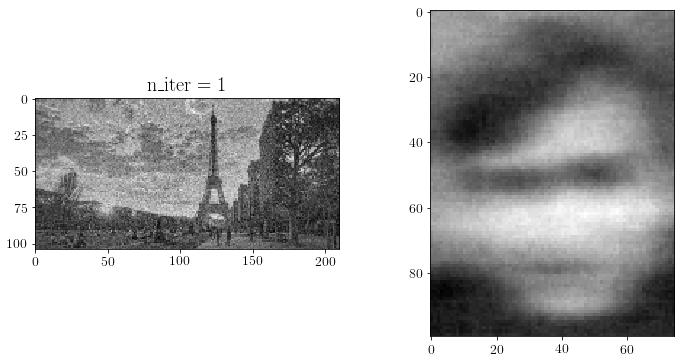

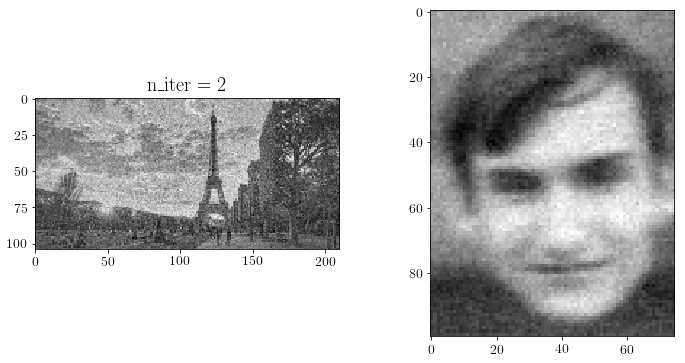

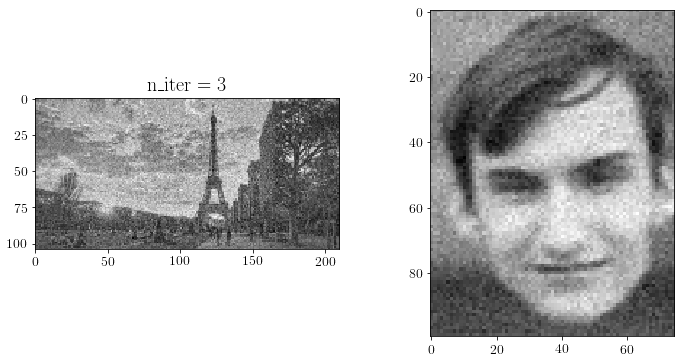

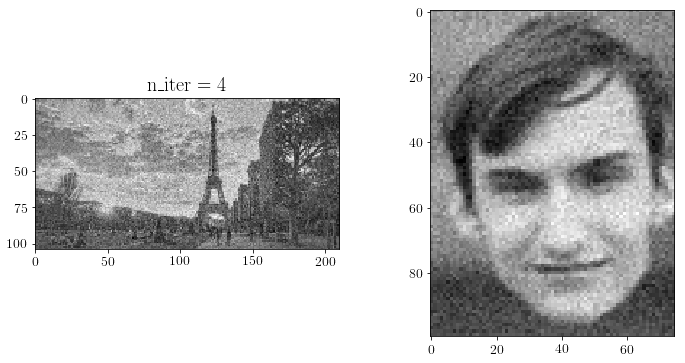

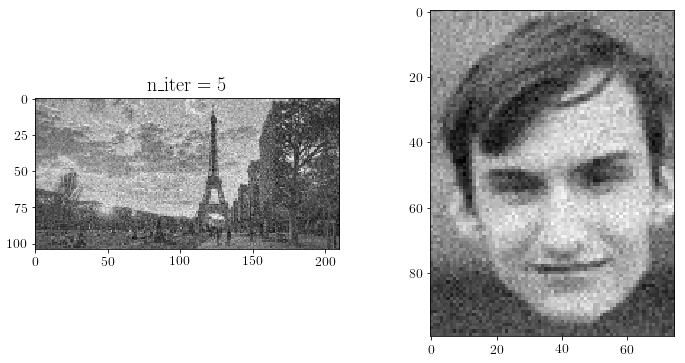

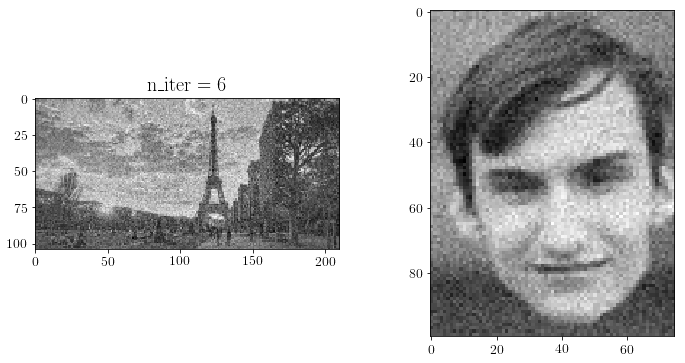

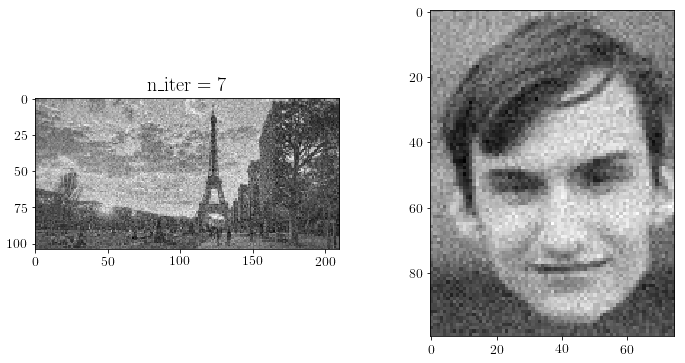

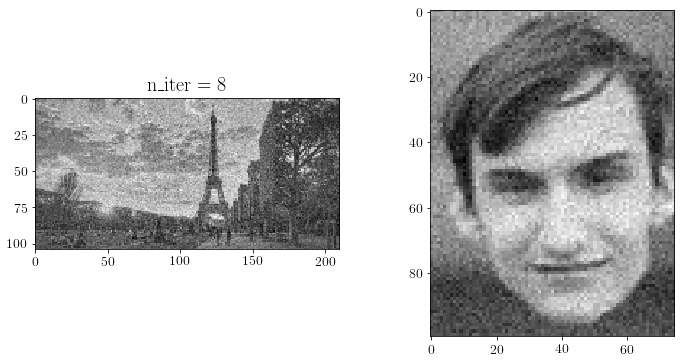

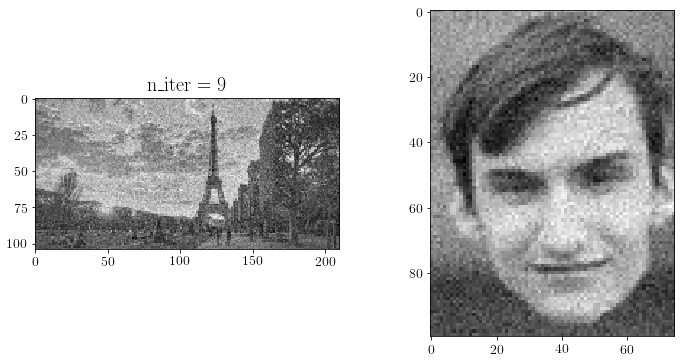

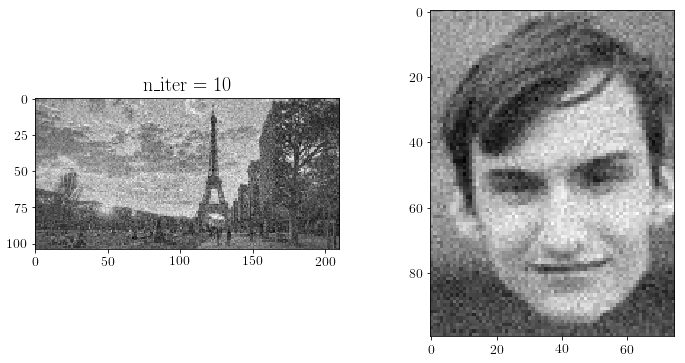

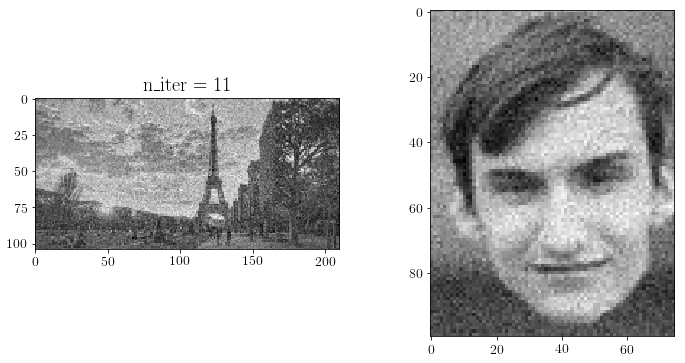

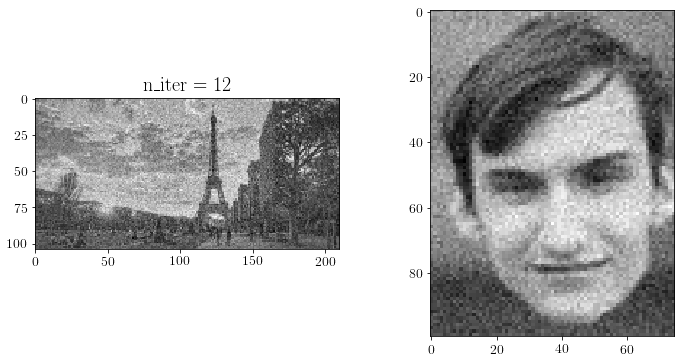

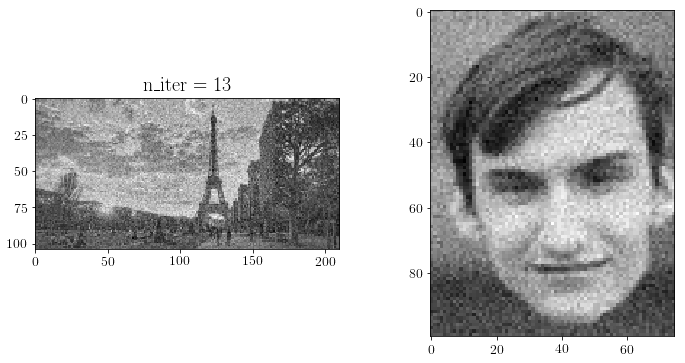

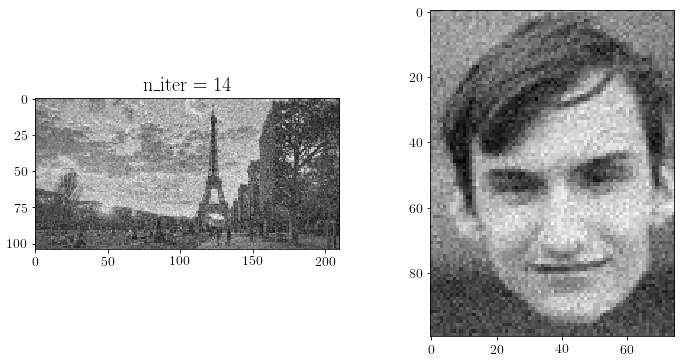

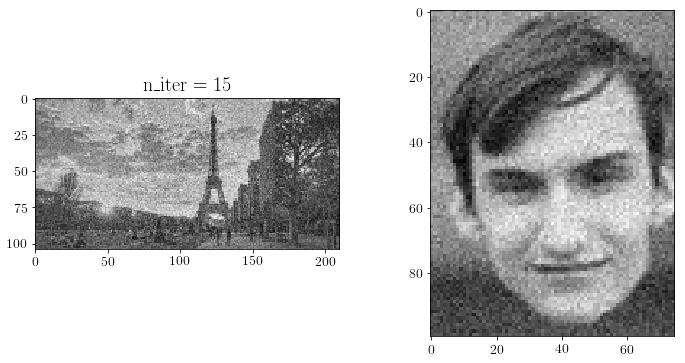

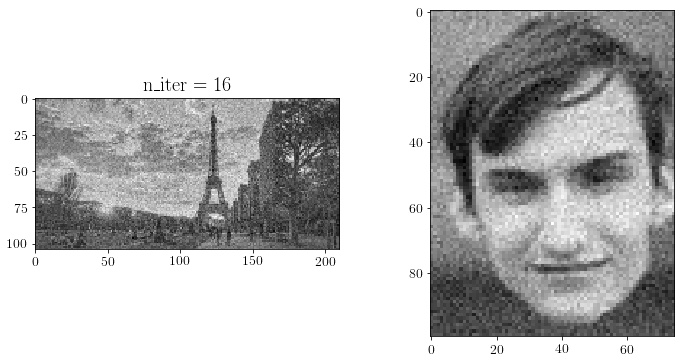

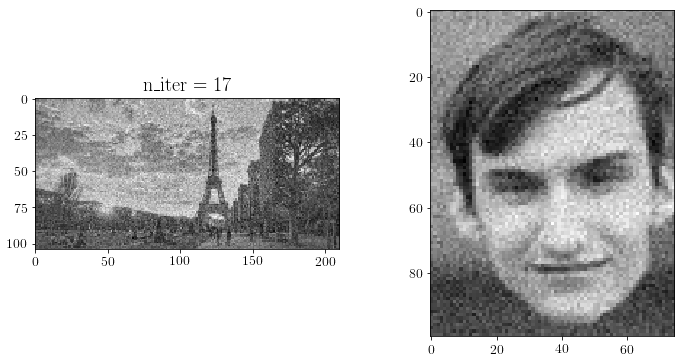

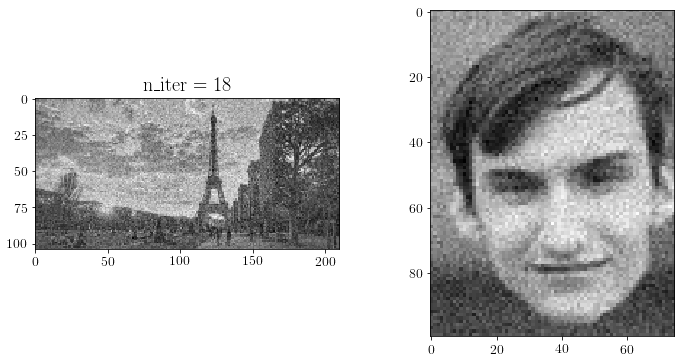

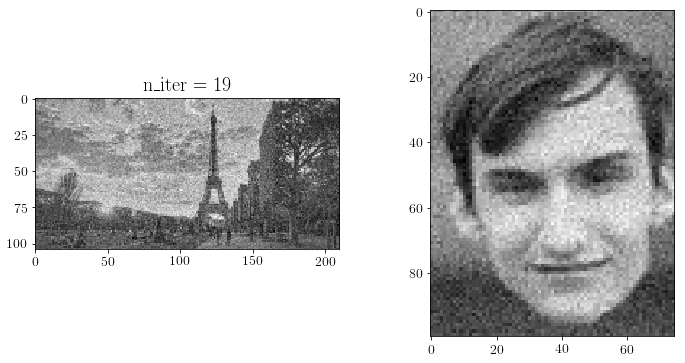

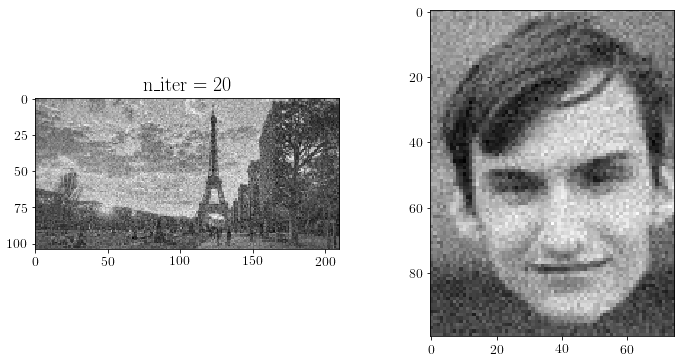

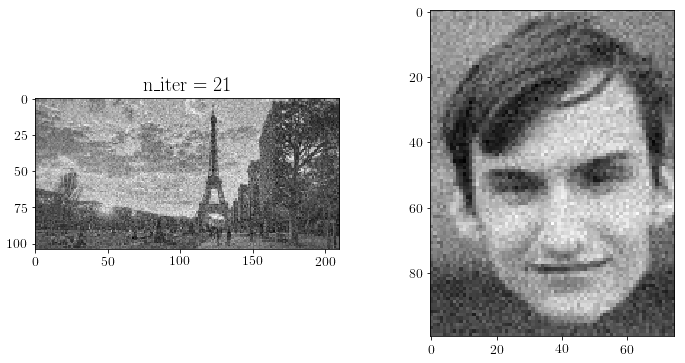

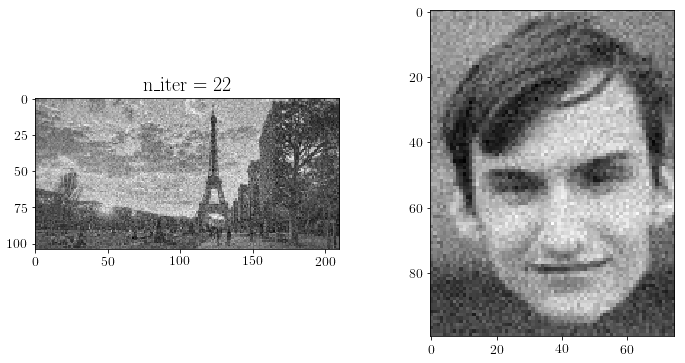

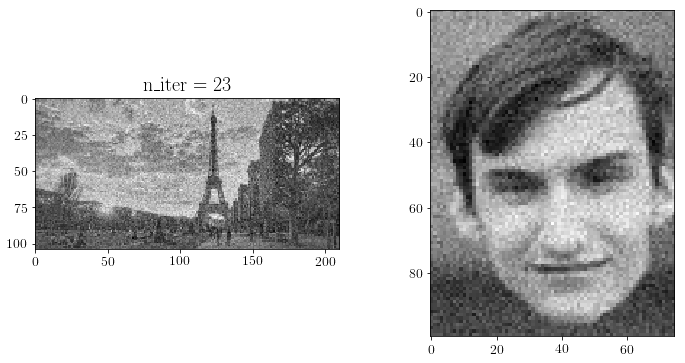

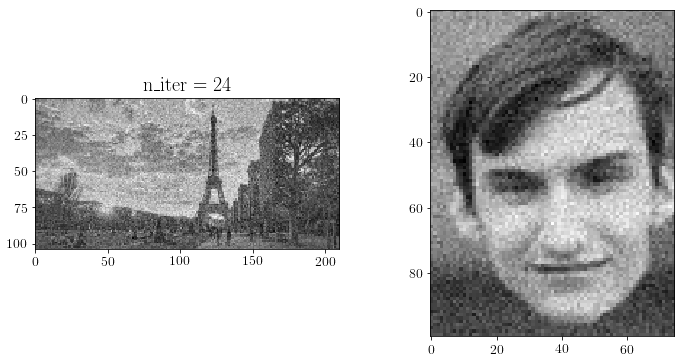

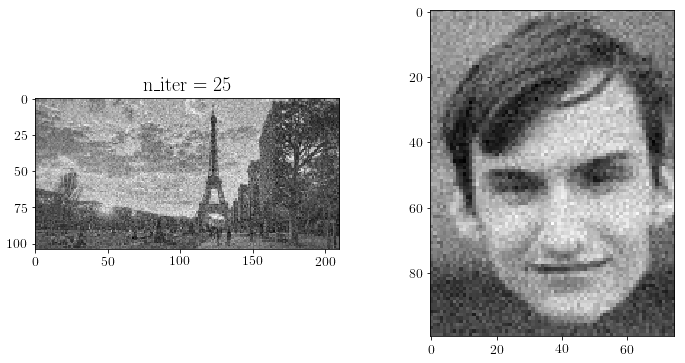

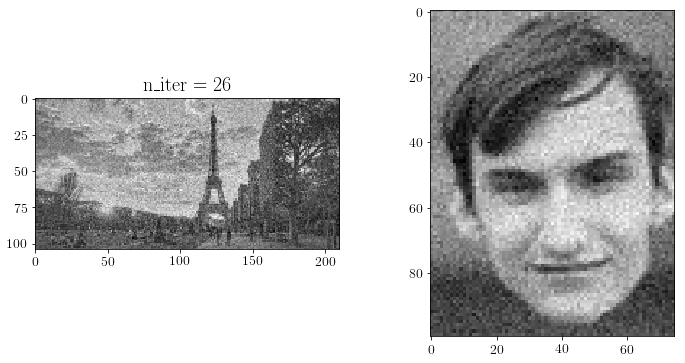

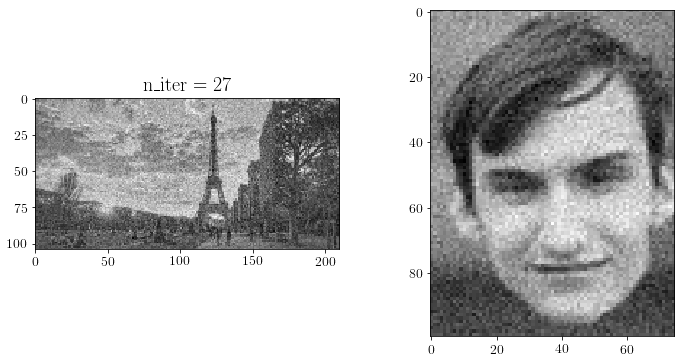

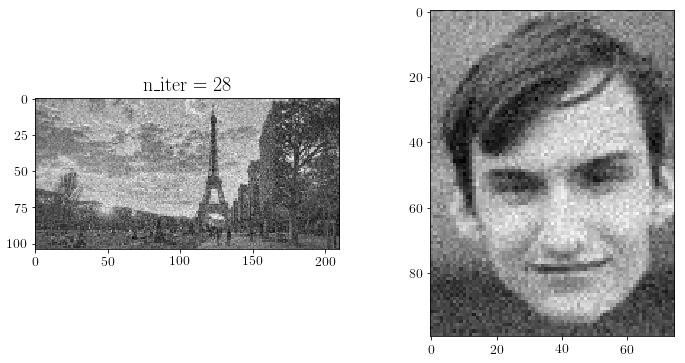

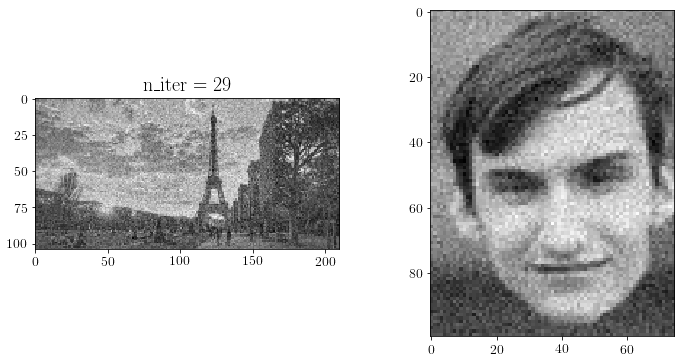

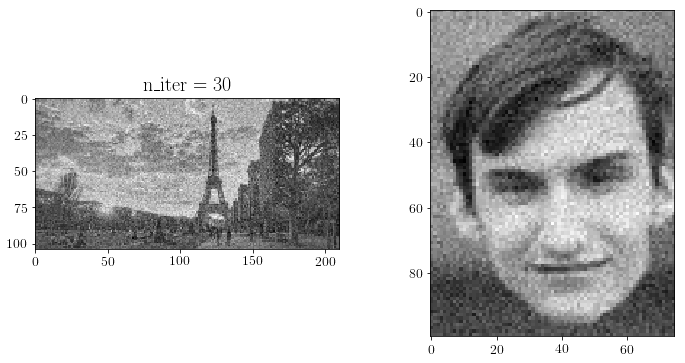

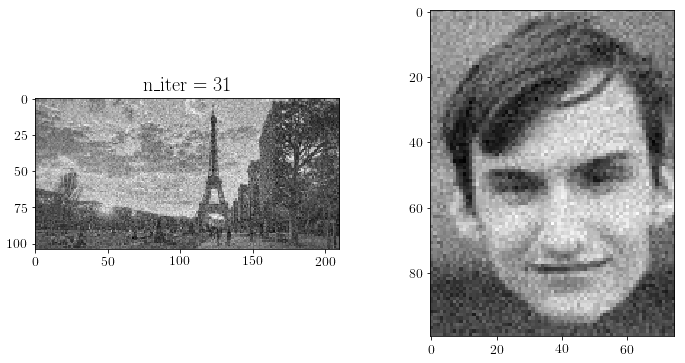

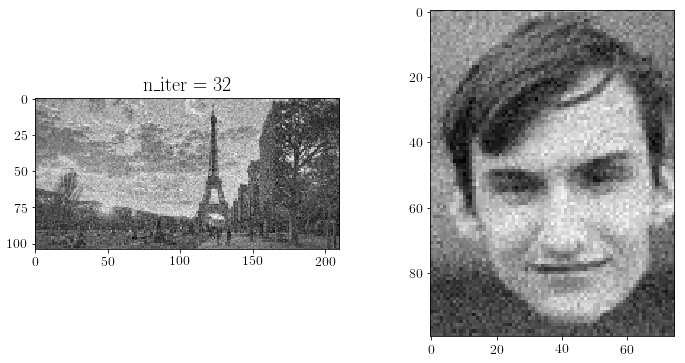

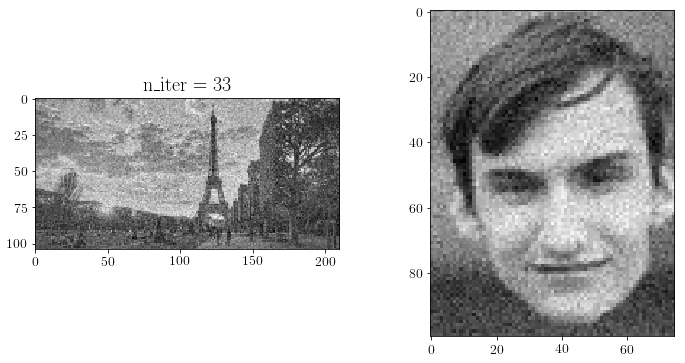

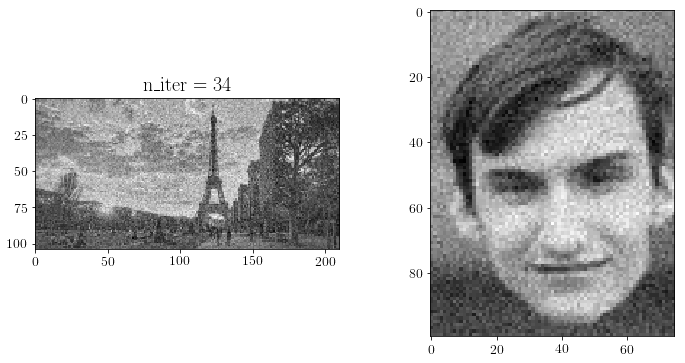

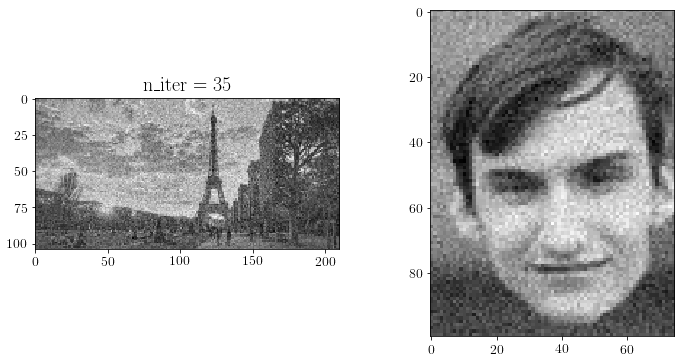

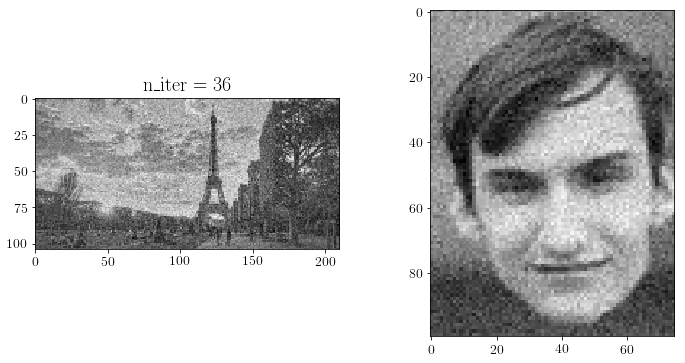

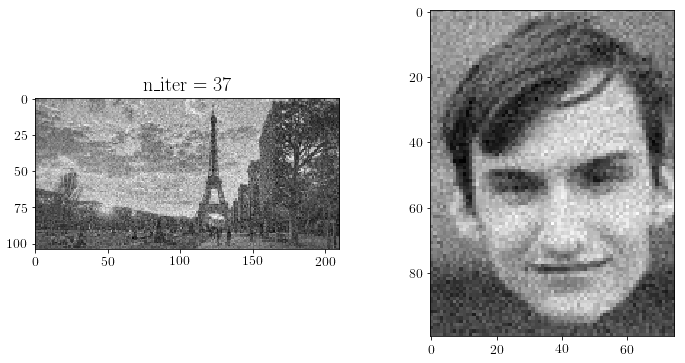

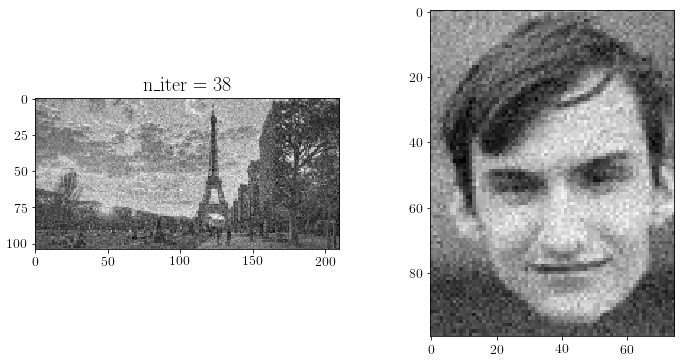

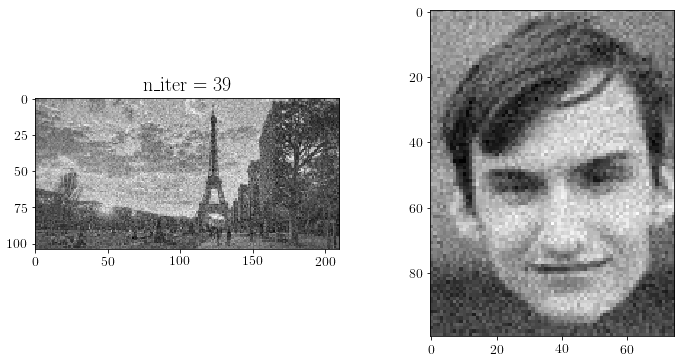

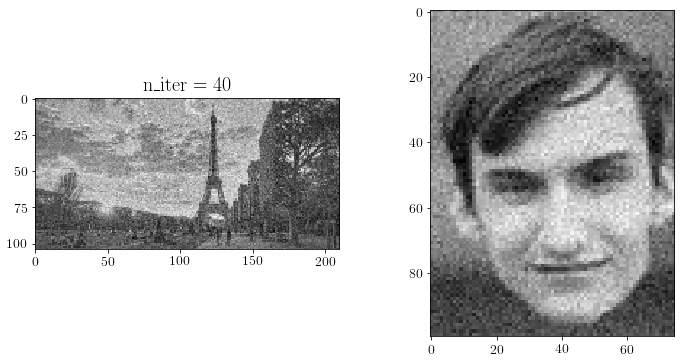

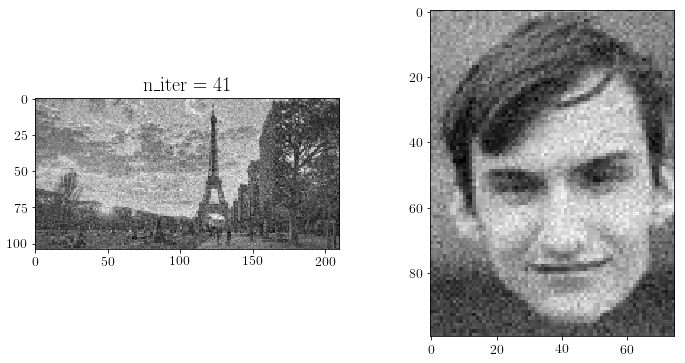

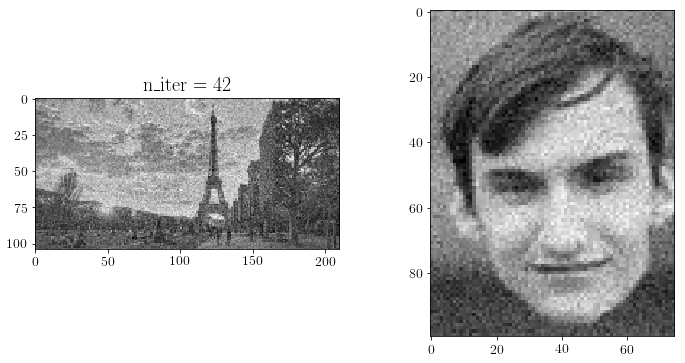

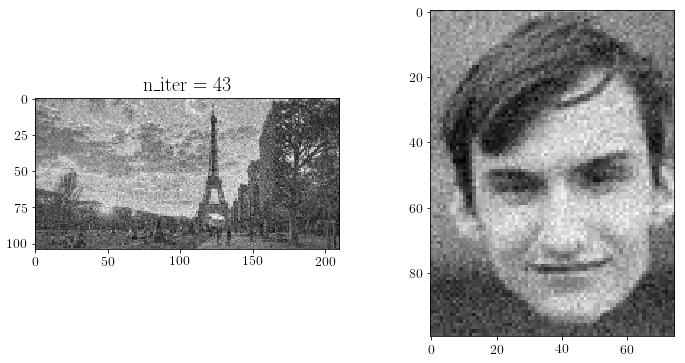

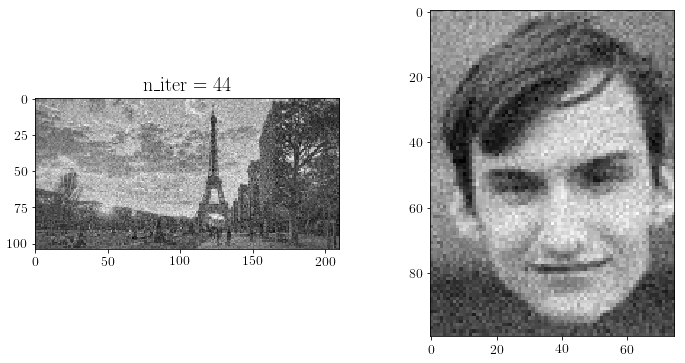

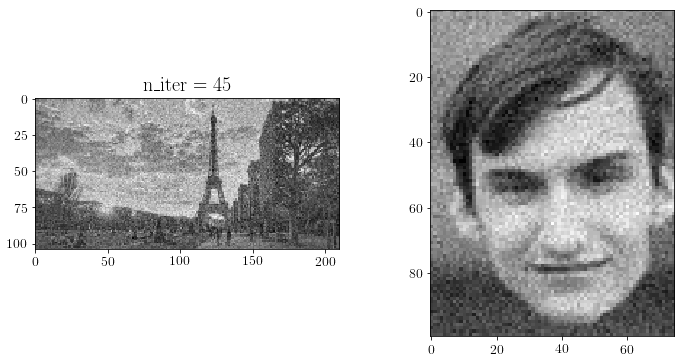

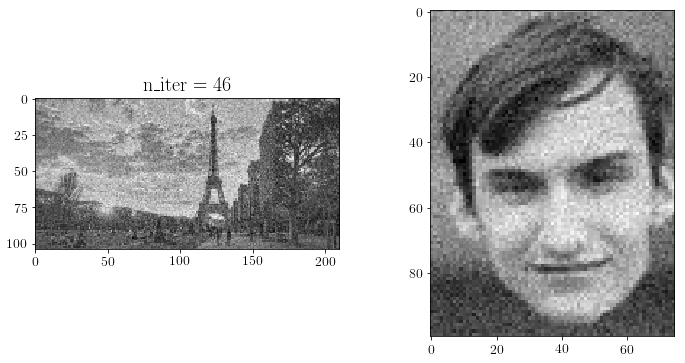

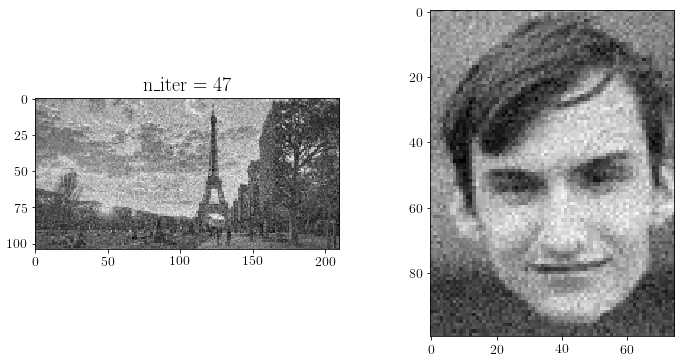

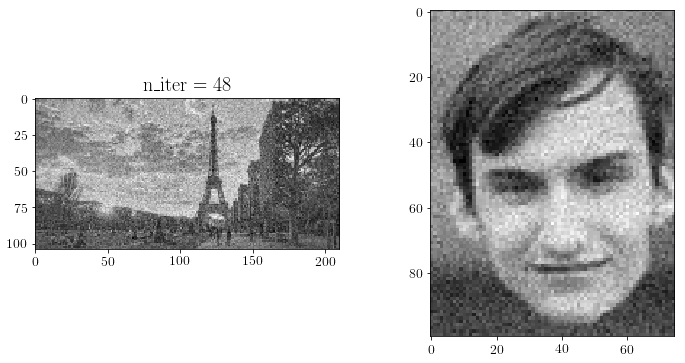

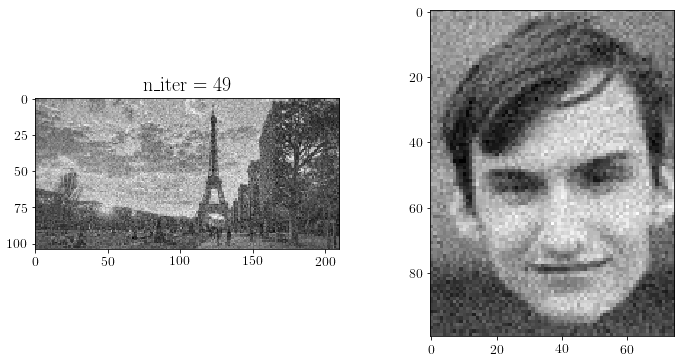

In [8]:
for n_iter in range(50):
    clear_output(True)
    F = algorithm()
    Ls = algorithm._lower_bounds
    B = algorithm.get_B()
    f, axarr = plt.subplots(1, 2, figsize=(12, 6))
    print('L[-2] = {}, L[-1] = {}'.format(Ls[-2], Ls[-1]))
    axarr[0].imshow(B, cmap='gray', interpolation='none');
    axarr[1].imshow(F, cmap='gray', interpolation='none');
    axarr[0].set_title('n\_iter = {}'.format(n_iter))
    display.display(plt.gcf())

In [26]:
class A:
    foo = 'foo'
    bar = 'bar'
    """Test class"""
    def __init__(self):
        pass
    def __call__(self, a):
        print(a)
    def __len__(self):
        return -1
    
print(A.__doc__)
for attr, value in A.__dict__.items():
    print(attr, ':',  value)
    
a = A()

print('\na.__class__ =', a.__class__)
print('a.__class__.__class__ =', a.__class__.__class__)
print('A.__class__ =', A.__class__)

None
__dict__ : <attribute '__dict__' of 'A' objects>
__call__ : <function A.__call__ at 0x7f615090a598>
__module__ : __main__
__doc__ : None
__init__ : <function A.__init__ at 0x7f615090a510>
bar : bar
__weakref__ : <attribute '__weakref__' of 'A' objects>
__len__ : <function A.__len__ at 0x7f615090a620>
foo : foo

a.__class__ = <class '__main__.A'>
a.__class__.__class__ = <class 'type'>
A.__class__ = <class 'type'>


<a id='interfaces'></a>
# Интерфейсы<sup>[toc](#toc)</sup>

In [ ]:
def calculate_log_probability(X, F, B, s):
    """
    Calculates log p(X_k|d_k,F,B,s) for all images X_k in X and
    all possible displacements d_k.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    F : array, shape (h, w)
        Estimate of villain's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.

    Returns
    -------
    ll : array, shape(H-h+1, W-w+1, K)
        ll[dh,dw,k] - log-likelihood of observing image X_k given
        that the villain's face F is located at displacement (dh, dw)
    """
    pass


def calculate_lower_bound(X, F, B, s, A, q, use_MAP=False):
    """
    Calculates the lower bound L(q,F,B,s,A) for the marginal log likelihood.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    F : array, shape (h, w)
        Estimate of villain's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.
    A : array, shape (H-h+1, W-w+1)
        Estimate of prior on displacement of face in any image.
    q : array
        If use_MAP = False: shape (H-h+1, W-w+1, K)
            q[dh,dw,k] - estimate of posterior of displacement (dh,dw)
            of villain's face given image Xk
        If use_MAP = True: shape (2, K)
            q[0,k] - MAP estimates of dh for X_k
            q[1,k] - MAP estimates of dw for X_k
    use_MAP : bool, optional
        If true then q is a MAP estimates of displacement (dh,dw) of
        villain's face given image Xk.

    Returns
    -------
    L : float
        The lower bound L(q,F,B,s,A) for the marginal log likelihood.
    """
    pass


def run_e_step(X, F, B, s, A, use_MAP=False, use_checks=False):
    """
    Given the current esitmate of the parameters, for each image Xk
    estimates the probability p(d_k|X_k,F,B,s,A).

    Parameters
    ----------
    X : array, shape(H, W, K)
        K images of size H x W.
    F  : array_like, shape(h, w)
        Estimate of villain's face.
    B : array shape(H, W)
        Estimate of background.
    s : scalar, shape(1, 1)
        Eestimate of standard deviation of Gaussian noise.
    A : array, shape(H-h+1, W-w+1)
        Estimate of prior on displacement of face in any image.
    use_MAP : bool, optional,
        If true then q is a MAP estimates of displacement (dh,dw) of
        villain's face given image Xk.

    Returns
    -------
    q : array
        If use_MAP = False: shape (H-h+1, W-w+1, K)
            q[dh,dw,k] - estimate of posterior of displacement (dh,dw)
            of villain's face given image Xk
        If use_MAP = True: shape (2, K)
            q[0,k] - MAP estimates of dh for X_k
            q[1,k] - MAP estimates of dw for X_k
    """
    H, W, K = X.shape
    h, w = F.shape
    if use_checks:
        assert A.shape == (H - h + 1, W - w + 1)
        assert B.shape == (H, W)
    pass


def run_m_step(X, q, h, w, use_MAP=False, use_checks=False):
    """
    Estimates F,B,s,A given esitmate of posteriors defined by q.

    Parameters
    ----------
    X : array, shape(H, W, K)
        K images of size H x W.
    q  :
        if use_MAP = False: array, shape (H-h+1, W-w+1, K)
           q[dh,dw,k] - estimate of posterior of displacement (dh,dw)
           of villain's face given image Xk
        if use_MAP = True: array, shape (2, K)
            q[0,k] - MAP estimates of dh for X_k
            q[1,k] - MAP estimates of dw for X_k
    h : int
        Face mask height.
    w : int
        Face mask width.
    use_MAP : bool, optional
        If true then q is a MAP estimates of displacement (dh,dw) of
        villain's face given image Xk.

    Returns
    -------
    F : array, shape (h, w)
        Estimate of villain's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.
    A : array, shape (H-h+1, W-w+1)
        Estimate of prior on displacement of face in any image.
    """
    K, H, W = X.shape
    h, w = F.shape
    if use_checks:
        assert A.shape == (H - h + 1, W - w + 1)
        assert B.shape == (H, W)
        assert G.shape == (K, H - h + 1, W - w + 1)
        assert s > 0
    pass


def run_EM(X, h, w, F=None, B=None, s=None, A=None, tolerance=0.001,
           max_iter=50, use_MAP=False):
    """
    Runs EM loop until the likelihood of observing X given current
    estimate of parameters is idempotent as defined by a fixed
    tolerance.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    h : int
        Face mask height.
    w : int
        Face mask width.
    F : array, shape (h, w), optional
        Initial estimate of villain's face.
    B : array, shape (H, W), optional
        Initial estimate of background.
    s : float, optional
        Initial estimate of standard deviation of Gaussian noise.
    A : array, shape (H-h+1, W-w+1), optional
        Initial estimate of prior on displacement of face in any image.
    tolerance : float, optional
        Parameter for stopping criterion.
    max_iter  : int, optional
        Maximum number of iterations.
    use_MAP : bool, optional
        If true then after E-step we take only MAP estimates of displacement
        (dh,dw) of villain's face given image Xk.

    Returns
    -------
    F, B, s, A : trained parameters.
    LL : array, shape(number_of_iters + 2,)
        L(q,F,B,s,A) at initial guess, after each EM iteration and after
        final estimate of posteriors;
        number_of_iters is actual number of iterations that was done.
    """
    pass


def run_EM_with_restarts(X, h, w, tolerance=0.001, max_iter=50, use_MAP=False,
                         n_restarts=10):
    """
    Restarts EM several times from different random initializations
    and stores the best estimate of the parameters as measured by
    the L(q,F,B,s,A).

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    h : int
        Face mask height.
    w : int
        Face mask width.
    tolerance, max_iter, use_MAP : optional parameters for EM.
    n_restarts : int
        Number of EM runs.

    Returns
    -------
    F : array,  shape (h, w)
        The best estimate of villain's face.
    B : array, shape (H, W)
        The best estimate of background.
    s : float
        The best estimate of standard deviation of Gaussian noise.
    A : array, shape (H-h+1, W-w+1)
        The best estimate of prior on displacement of face in any image.
    L : float
        The best L(q,F,B,s,A).
    """
    pass

In [ ]:
import sys
import time
import numpy as np
from nose.tools import ok_, eq_
from numpy.testing import assert_almost_equal
import Student as model


def test_python3():
    ok_(sys.version_info > (3, 3))


def check_shape(**kwargs):
    np.random.seed(42)
    H, W, K = 10, 12, 20
    h, w = 4, 5
    max_iter = 1
    X = np.random.rand(H, W, K)
    F, B, s, A, LL = model.run_EM(X, h, w, max_iter=max_iter, **kwargs)
    eq_(F.shape, (h, w))
    eq_(B.shape, (H, W))
    eq_(A.shape, (H-h+1, W-w+1))
    eq_(np.array(LL).shape, (max_iter+2,))


def generate_data(H, W, K, h, w, use_MAP=False, seed=42):
    # explicit data with no noise
    np.random.seed(seed)
    X = np.zeros((H, W, K))
    F = np.zeros((h, w))
    B = np.random.rand(H, W)

    coords = []
    q = np.zeros((H-h+1, W-w+1, K))
    for k in range(K):
        x = np.random.randint(0, H-h+1)
        y = np.random.randint(0, W-w+1)
        coords.append((x, y))
        X[:, :, k] = np.copy(B)
        X[x:x+h, y:y+w, k] = F
        q[x, y, k] = 1.

    A = np.random.rand(H - h + 1, W - w + 1)
    A /= A.sum()

    if use_MAP:
        q = np.array(coords).T

    return X, F, B, A, q


def check_e_step(use_MAP=False):
    H, W, K = 4, 5, 2
    h, w = 2, 3
    s = 1e-1
    X, F, B, A, q = \
        generate_data(H, W, K, h, w, use_MAP=use_MAP)

    pred_q = model.run_e_step(X, F, B, s, A, use_MAP=use_MAP)
    if use_MAP:
        assert_almost_equal(q, pred_q)
    else:
        assert_almost_equal(q, pred_q, 5)


def check_m_step(use_MAP=False):
    H, W, K = 7, 8, 2
    h, w = 2, 3
    X, F, B, A, q = generate_data(H, W, K, h, w, use_MAP=use_MAP)

    pred_F, pred_B, pred_s, pred_A = \
        model.run_m_step(X, q, h, w, use_MAP=use_MAP)

    assert_almost_equal(F, pred_F)
    assert_almost_equal(B, pred_B)


def check_e_step_time(use_MAP=False):
    H, W, K = 50, 100, 50
    h, w = 40, 50
    s = 0.1
    X, F, B, A, q = generate_data(H, W, K, h, w)
    t_start = time.perf_counter()
    model.run_e_step(X, F, B, s, A, use_MAP=use_MAP)
    computation_time = time.perf_counter() - t_start
    assert computation_time < 1


def check_m_step_time(use_MAP=False):
    H, W, K = 50, 100, 50
    h, w = 40, 50
    X, F, B, A, q = generate_data(H, W, K, h, w, use_MAP=use_MAP)

    t_start = time.perf_counter()
    model.run_m_step(X, q, h, w, use_MAP=use_MAP)
    computation_time = time.perf_counter() - t_start
    assert computation_time < 1


def test_output_shape():
    check_shape()
    check_shape(use_MAP=True)


def test_e_step():
    check_e_step()
    check_e_step(use_MAP=True)


def test_m_stap():
    check_m_step()
    check_m_step(use_MAP=True)


def test_e_step_time():
    check_e_step_time()
    check_e_step_time(use_MAP=True)


def test_m_step_time():
    check_m_step_time()
    check_m_step_time(use_MAP=True)